# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \theta & \dot{x} & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
from ilqr.cost import QRCost, FiniteDiffCost
from ilqr.mujoco_dynamics import MujocoDynamics
from ilqr.mujoco_controller import iLQR
from ilqr.examples.cartpole import CartpoleDynamics
from ilqr.dynamics import constrain
from ilqr.utils.visualization import make_video_fn

from scipy.optimize import approx_fprime

import mujoco_py
from mujoco_py import MjViewer
import os

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
xml_path = os.path.join('..', 'ilqr', 'xmls', 'inverted_pendulum.xml')
dynamics = MujocoDynamics(xml_path, frame_skip = 2, use_multiprocessing = True)
print(dynamics.dt)


Finished loading process 55146
Finished loading process 55147
Finished loading process 55148
Finished loading process 55149
Finished loading process 55150
Finished loading process 55151
Finished loading process 55152
Finished loading process 55153
Finished loading process 55154
Finished loading process 55155
Finished loading process 55156
Finished loading process 55157
0.04
Finished loading process 55158
Finished loading process 55159
Finished loading process 55160
Finished loading process 55161


In [7]:
x_goal = np.array([0.0, 0.0, 0.0, 0.0])

# Instantenous state cost.
Q = np.eye(4)
Q[0, 0] = 2.0
Q[1, 1] = 10.0


# Terminal state cost.
Q_terminal = 100 * Q

# Instantaneous control cost.
R = np.eye(1)

cost1 = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
cost2 = FiniteDiffCost(lambda x, u, i: 2 * (x[0] ** 2) + 10 * (x[1] ** 2) + x[2] ** 2 + x[3] ** 2 + u[0] ** 2,
                      lambda x, i: 100 * (2 * (x[0] ** 2) + 10 * (x[1] ** 2) + x[2] ** 2 + x[3] ** 2),
                      4, 1, use_multiprocessing = True)

Finished loading process 55162
Finished loading process 55163
Finished loading process 55164
Finished loading process 55165
Finished loading process 55166
Finished loading process 55167
Finished loading process 55168
Finished loading process 55169
Finished loading process 55170
Finished loading process 55171
Finished loading process 55172
Finished loading process 55173
Finished loading process 55174
Finished loading process 55175
Finished loading process 55176
Finished loading process 55177


In [9]:
N = 100
x0 = np.array([0.0, np.pi - 1, 0.0, 0.0])
us_init = np.array([[-4.76751939e-01],
 [ 3.34490970e-01],
 [-3.99608551e-01],
 [ 8.41882163e-01],
 [-8.93302461e-01],
 [-3.57273055e-01],
 [-3.32158856e-01],
 [-4.82030121e-01],
 [-6.84388675e-01],
 [-4.26475287e-01],
 [-4.90913171e-01],
 [ 1.14754770e-01],
 [ 3.90275383e-01],
 [-4.36421243e-01],
 [ 5.57806778e-01],
 [ 7.83813923e-01],
 [-3.27778717e-01],
 [ 8.00582346e-01],
 [-8.49640982e-01],
 [-5.69222128e-01],
 [ 2.58447724e-01],
 [ 6.02857039e-01],
 [-6.11855326e-01],
 [ 7.00853348e-01],
 [-9.31090157e-01],
 [ 4.97665652e-01],
 [ 2.45721323e-01],
 [-1.92025996e-01],
 [ 2.72219728e-02],
 [ 7.95701514e-01],
 [-8.92320606e-01],
 [ 3.22802941e-02],
 [ 2.69562194e-01],
 [-1.46125346e-01],
 [-3.15934186e-02],
 [ 6.61809200e-01],
 [ 4.76622656e-01],
 [-9.78007260e-01],
 [ 5.73481914e-01],
 [-1.28208542e-02],
 [ 1.48147746e-01],
 [ 1.39421731e-04],
 [ 1.08812740e-01],
 [ 6.16007441e-01],
 [ 2.66982969e-01],
 [-2.09250070e-02],
 [ 6.04343953e-02],
 [ 4.14836049e-01],
 [-7.01346473e-01],
 [ 2.94563133e-01],
 [-3.07180590e-01],
 [ 6.53429823e-01],
 [ 3.87696411e-01],
 [-1.60361255e-01],
 [-7.91982930e-01],
 [ 3.04331662e-01],
 [-3.33057338e-01],
 [-1.45487867e-01],
 [-4.48293362e-01],
 [-4.56753222e-01],
 [-5.63113978e-02],
 [ 9.17106858e-01],
 [-7.79117478e-01],
 [-7.74944928e-01],
 [ 1.26081663e-01],
 [ 8.11397037e-02],
 [-6.58667412e-01],
 [ 9.01877119e-01],
 [-7.59017615e-01],
 [-6.54909707e-01],
 [-7.19152458e-01],
 [-8.23250291e-01],
 [-1.96576912e-01],
 [ 3.31076346e-01],
 [-9.59322994e-01],
 [ 6.61615691e-01],
 [-4.48940253e-01],
 [-4.10547311e-01],
 [-8.26340358e-01],
 [ 7.48939731e-01],
 [-8.83894866e-01],
 [ 4.12684469e-01],
 [-4.61578622e-01],
 [-8.29689676e-01],
 [-9.02561735e-01],
 [-2.44970624e-01],
 [ 2.86652487e-01],
 [-8.59512109e-01],
 [-5.89043961e-01],
 [ 6.21286175e-01],
 [-4.02464523e-01],
 [-7.80221770e-01],
 [-7.58513349e-01],
 [ 5.35469863e-01],
 [ 7.43535637e-01],
 [ 9.40814704e-01],
 [-9.31071558e-01],
 [-4.20465454e-01],
 [-1.28056017e-01],
 [-2.09487816e-01]])
#us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost2, N)

In [10]:
t0 = time.time()
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)
print('\n\n\n\n\n')
print('time', time.time() - t0)

iteration 0 accepted 21002.37711588231 [-1.95745543  1.69610593 -0.53265088 -7.17418518]
iteration 1 accepted 18584.912064922064 [-1.94189518  2.40504485  0.76980115 -0.06023402]
iteration 2 accepted 15381.538567105154 [-1.84935869  1.4458722  -0.45325937 -2.45609029]
iteration 3 accepted 14850.625421897461 [-1.91190265  1.07496853 -0.5245862  -3.26349722]
iteration 4 accepted 14489.543739328981 [-0.65976443  1.25460407  0.89606997 -1.98072619]
iteration 5 accepted 14425.48382952622 [-1.70395284  1.0411754  -0.27261936 -1.82724089]
iteration 6 accepted 13985.691189510868 [-1.50024951  0.98128662 -0.22805151 -1.79124248]
iteration 7 accepted 12916.40240697523 [-0.46875253  0.81959531  0.85494922 -1.67818994]
iteration 8 accepted 12265.725791566669 [-0.55780647  0.85340206 -0.66211663 -2.3189491 ]
iteration 9 accepted 11813.665450965154 [-0.31158322  1.007789    0.28908545 -1.35648071]
iteration 10 accepted 11729.203648032426 [-0.31364788  1.05981814 -0.02744643 -1.99811437]
iteration 11

iteration 92 accepted 7977.316162322272 [-0.08823645 -0.03186109  0.28617322  0.13260977]
iteration 93 accepted 7970.46933061962 [-0.0566828  -0.03184926  0.29555509  0.13789234]
iteration 94 accepted 7938.922964295634 [-0.31949951 -0.04442468  0.29894562  0.14962086]
iteration 95 accepted 7915.695209786756 [-0.38134262 -0.04672428  0.29501885  0.14456277]
iteration 96 accepted 7910.893951589211 [-0.47613179 -0.05103742  0.29806973  0.14310901]
iteration 97 accepted 7894.28635675972 [-0.18643922 -0.0436783   0.3182338   0.17969114]
iteration 98 accepted 7868.157266993034 [-0.32885345 -0.05112146  0.32997991  0.17910899]
iteration 99 accepted 7813.472487865283 [-0.29401855 -0.04823123  0.31688449  0.16042207]
iteration 100 accepted 7798.378881394088 [-0.37107165 -0.05155871  0.31909586  0.15803957]
iteration 101 accepted 7769.827463457564 [-0.22740714 -0.04427031  0.29906691  0.14707348]
iteration 102 accepted 7749.597983471614 [-0.36303324 -0.04988661  0.30195108  0.14657207]
iteration

iteration 189 accepted 5841.009371723801 [-0.15022867 -0.03143361  0.1602259   0.07761745]
iteration 190 accepted 5795.675351983697 [-0.10664179 -0.02484588  0.12408179  0.06148162]
iteration 191 accepted 5781.091265828589 [-0.10284026 -0.02351347  0.11953294  0.0565363 ]
iteration 192 accepted 5763.216442103376 [-0.07842803 -0.01959137  0.09838339  0.04698278]
iteration 193 accepted 5745.223848694622 [-0.00635927 -0.00824187  0.0355559   0.02031287]
iteration 194 accepted 5719.564429667545 [-0.07477305 -0.0186735   0.09268546  0.04598643]
iteration 195 accepted 5698.562596195894 [-0.13177725 -0.02796305  0.14280548  0.0683976 ]
iteration 196 accepted 5678.873382441175 [-0.05918352 -0.01685495  0.0810786   0.04192423]
iteration 197 accepted 5657.3982966292515 [-0.09051626 -0.02182678  0.10832531  0.0537778 ]
iteration 198 accepted 5615.952260353646 [-0.09242476 -0.02166243  0.10891199  0.05241945]
iteration 199 accepted 5614.605967056082 [-0.14033536 -0.02956663  0.15155298  0.07130605

iteration 284 accepted 3706.5452400917857 [ 0.01247332  0.00145732 -0.00924672 -0.00413715]
iteration 285 accepted 3691.5383381913043 [ 0.00807466  0.0006173  -0.00478475 -0.00206038]
iteration 286 accepted 3681.7478488968704 [ 0.01187226  0.00146153 -0.00907915 -0.00403327]
iteration 287 accepted 3627.1028184822085 [-0.00459526 -0.00207145  0.00904419  0.00431426]
iteration 288 accepted 3620.263323048694 [-0.00248304 -0.00165264  0.0068278   0.00329821]
iteration 289 accepted 3616.663802151191 [ 0.00133588 -0.00092364  0.00293118  0.00152153]
iteration 290 accepted 3601.121567389269 [ 0.00906378  0.00079186 -0.00579941 -0.00249379]
iteration 291 accepted 3598.3842870065187 [-0.02517684 -0.00664995  0.03210913  0.01510569]
iteration 292 accepted 3571.44691857092 [-0.00076099 -0.00135043  0.00488317  0.00267886]
iteration 293 accepted 3527.3447981650706 [-0.0071528  -0.00270412  0.0119169   0.00585564]
iteration 294 accepted 3502.7729401062697 [ 4.11813668e-03 -1.82882215e-04 -8.0609151

iteration 373 accepted 1896.4916734559447 [ 0.00049457 -0.00017809  0.00052601  0.00028327]
iteration 374 accepted 1887.777656975406 [ 1.24108362e-03  1.29403531e-05 -3.99081352e-04 -1.46350678e-04]
iteration 375 accepted 1882.4104946211496 [ 1.01075483e-03 -4.12864070e-05 -1.28270479e-04 -2.12653261e-05]
iteration 376 accepted 1880.1549710554057 [ 0.00166111  0.00012204 -0.0009251  -0.00039087]
iteration 377 accepted 1878.2498342336185 [ 0.0017488   0.00014341 -0.00103083 -0.00043981]
iteration 378 accepted 1878.1530298918262 [ 0.00232424  0.00028503 -0.00172713 -0.00076236]
iteration 379 accepted 1877.2295546522337 [ 0.00235054  0.00029135 -0.00175864 -0.00077694]
iteration 380 accepted 1876.9093908718667 [ 0.00244205  0.00031418 -0.00187028 -0.0008287 ]
iteration 381 accepted 1876.9027272703254 [ 0.00250933  0.00033132 -0.0019535  -0.00086734]
iteration 382 accepted 1876.8556683749837 [ 0.00252852  0.00033613 -0.00197699 -0.00087823]
iteration 383 accepted 1876.8495315282898 [ 0.002

In [11]:
t = np.arange(N + 1) * dynamics.dt
x = xs[:, 0]
x_dot = xs[:, 2]
theta = np.unwrap(xs[:, 1])  # Makes for smoother plots.
theta_dot = xs[:, 3]

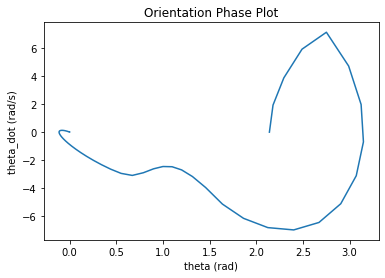

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

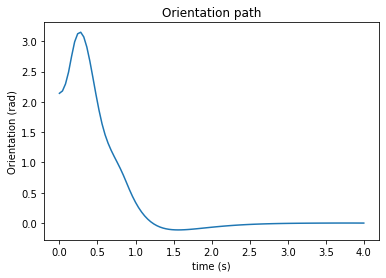

In [42]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

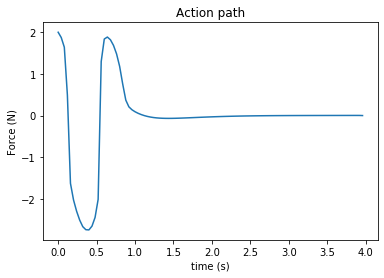

In [43]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

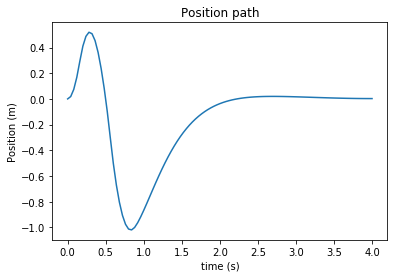

In [44]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

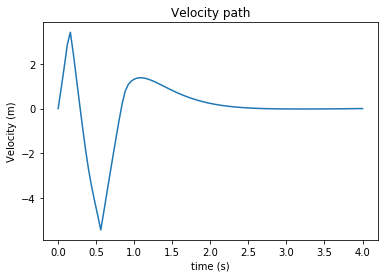

In [45]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

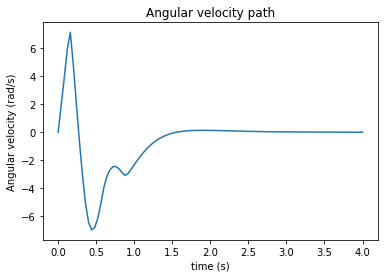

In [46]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

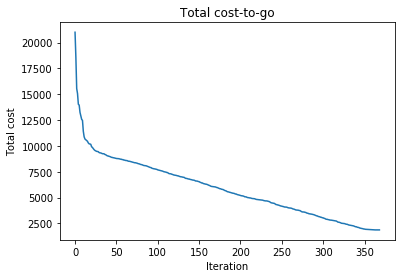

In [47]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")

In [48]:
dynamics.set_state(x0)
print(dynamics.get_state())
video = []
for i, u in enumerate(us):
    print (i, u)
    print(xs[i+1], dynamics.step(u))
    print('')
    video.append(dynamics.sim.render(512, 512))
make_video_fn(video)()

Creating window glfw
[0.         2.14159265 0.         0.        ]
0 [1.9980842]
[0.01835764 2.18039918 0.92008372 1.93082176] [0.01835764 2.18039918 0.92008372 1.93082176]

1 [1.87088408]
[0.07388471 2.29608299 1.86542366 3.86896442] [0.07388471 2.29608299 1.86542366 3.86896442]

2 [1.63905907]
[0.16803653 2.4911347  2.85559211 5.91490111] [0.16803653 2.4911347  2.85559211 5.91490111]

3 [0.49041769]
[0.29357379 2.75228147 3.42053472 7.12149979] [0.29357379 2.75228147 3.42053472 7.12149979]

4 [-1.62831889]
[0.4111702  2.99061806 2.43835268 4.71346845] [0.4111702  2.99061806 2.43835268 4.71346845]

5 [-2.02777121]
[0.48693342 3.12431104 1.34768911 1.97065637] [0.48693342 3.12431104 1.34768911 1.97065637]

6 [-2.29710191]
[ 0.518831    3.14919475  0.25123576 -0.69180678] [ 0.518831    3.14919475  0.25123576 -0.69180678]

7 [-2.50944193]
[ 0.50728711  3.07213291 -0.82184481 -3.10654112] [ 0.50728711  3.07213291 -0.82184481 -3.10654112]

8 [-2.66651761]
[ 0.45378273  2.90613261 -1.839292

70 [-0.00327901]
[ 0.01862029 -0.00834497 -0.01117078  0.02664496] [ 0.01862029 -0.00834497 -0.01117078  0.02664496]

71 [-0.00279065]
[ 0.01813304 -0.00733472 -0.01321521  0.02410912] [ 0.01813304 -0.00733472 -0.01321521  0.02410912]

72 [-0.00235134]
[ 0.017571   -0.00642107 -0.01490884  0.02179322] [ 0.017571   -0.00642107 -0.01490884  0.02179322]

73 [-0.00195655]
[ 0.01694744 -0.00559547 -0.01628868  0.0196853 ] [ 0.01694744 -0.00559547 -0.01628868  0.0196853 ]

74 [-0.001602]
[ 0.01627427 -0.0048499  -0.01738801  0.01777308] [ 0.01627427 -0.0048499  -0.01738801  0.01777308]

75 [-0.00128367]
[ 0.0155621  -0.00417681 -0.01823665  0.01604407] [ 0.0155621  -0.00417681 -0.01823665  0.01604407]

76 [-0.00099779]
[ 0.01482044 -0.00356915 -0.01886116  0.01448568] [ 0.01482044 -0.00356915 -0.01886116  0.01448568]

77 [-0.00074081]
[ 0.01405778 -0.00302039 -0.01928506  0.01308522] [ 0.01405778 -0.00302039 -0.01928506  0.01308522]

78 [-0.00050945]
[ 0.01328174 -0.00252448 -0.01952905  0.0